# Predicting BMI from psychological variables - Classification

In [108]:
# Load libraries
import numpy as np
from numpy import arange
import pickle
#
import matplotlib.pyplot as plt

#
import pandas as pd
from pandas import read_csv

from sklearn.metrics import confusion_matrix,  classification_report, f1_score
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.externals import joblib
from sklearn.utils.multiclass import unique_labels

import tensorflow
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [109]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tensorflow.set_random_seed(RANDOM_SEED)

In [110]:
with open('../data/X_paper.pkl', 'rb') as f:
    X = pickle.load(f)

with open('../data/y_paper.pkl', 'rb') as f:
    y = pickle.load(f)

In [111]:
"""X = pd.DataFrame(X)
y = pd.DataFrame(y)"""

'X = pd.DataFrame(X)\ny = pd.DataFrame(y)'

In [112]:
X

array([[  22,  110,  101,  222,    0],
       [  21,  102,  100,  220,    0],
       [  21,  102,  100,  212,    0],
       ...,
       [ 111,  122,  112, 1120,    0],
       [ 111,  122,  112, 1120,    0],
       [ 111,  122,  112, 1112,    0]])

In [113]:
X = np.concatenate((X[:250], X[750:1000], X[1500:]), axis=0)
y = np.concatenate((y[:250], y[750:1000], y[1500:]), axis=0)

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)

## Model Spotting

In [115]:
# Test options and evaluation metric
num_folds = 10
seed = 42
scoring = 'f1_macro'


In [116]:
y_train

array([5, 1, 4, 4, 5, 4, 5, 1, 4, 0, 5, 1, 4, 0, 4, 0, 4, 4, 1, 0, 0, 4,
       0, 4, 0, 0, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 0, 0, 4, 4, 4, 1,
       5, 5, 0, 4, 1, 4, 5, 1, 0, 0, 1, 4, 0, 4, 0, 4, 1, 1, 1, 4, 1, 0,
       4, 0, 4, 4, 4, 4, 4, 0, 0, 4, 4, 5, 0, 5, 4, 0, 4, 4, 1, 0, 0, 5,
       0, 4, 4, 4, 4, 5, 4, 1, 1, 1, 5, 0, 1, 4, 1, 1, 4, 1, 4, 4, 4, 0,
       5, 4, 4, 4, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 4, 4, 4, 1, 4, 0, 1, 4,
       5, 1, 0, 0, 5, 0, 1, 4, 0, 4, 1, 4, 4, 0, 1, 4, 4, 4, 0, 5, 4, 0,
       0, 0, 0, 0, 4, 0, 0, 4, 4, 0, 4, 0, 4, 4, 4, 5, 0, 0, 5, 1, 4, 5,
       0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 4, 4, 5, 4, 0, 0, 4, 4, 0, 0, 0, 4,
       1, 4, 1, 5, 0, 4, 5, 0, 4, 1, 4, 1, 4, 4, 4, 1, 5, 0, 5, 0, 1, 0,
       4, 4, 5, 4, 0, 4, 0, 4, 1, 4, 4, 0, 1, 0, 5, 4, 5, 4, 4, 4, 4, 0,
       0, 0, 4, 4, 1, 1, 0, 0, 4, 0, 4, 1, 0, 1, 5, 5, 4, 4, 4, 4, 0, 1,
       4, 1, 4, 5, 4, 1, 0, 1, 4, 0, 1, 0, 4, 4, 5, 4, 1, 1, 4, 4, 4, 0,
       1, 1, 4, 4, 0, 1, 4, 1, 1, 1, 0, 0, 1, 4, 4,

In [117]:
# Spot-Check Algorithms
models = []
'''
models.append(('CART' , DecisionTreeClassifier(random_state=seed)))
models.append(('SVC' , SVC(gamma='auto', random_state=seed)))
models.append(('AB',  AdaBoostClassifier(random_state=seed, n_estimators = 50)))
models.append(('RF',  RandomForestClassifier(random_state=seed, n_estimators = 50)))
models.append(('ET',  ExtraTreesClassifier(random_state=seed, n_estimators = 50)))
'''

models.append(('LR', Pipeline([('Scaler', StandardScaler()),('CART', LogisticRegression(random_state=seed))])))
models.append(('CART' , DecisionTreeClassifier(random_state=seed)))
models.append(('SVC' , SVC(gamma=0.5, random_state=seed)))
models.append(('AB', AdaBoostClassifier(random_state=seed, n_estimators = 50)))
models.append(('RF', RandomForestClassifier(random_state=seed, n_estimators = 50)))
models.append(('ET', ExtraTreesClassifier(random_state=seed, n_estimators = 50)))


In [122]:
results = []
names = []
for name, model in models:
    # Dividere dati in n = num_folds
    kf = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = np.array([])
    for train_idx, test_idx, in kf.split(X_train, y_train):
        X_cross_train, y_cross_train = X_train[train_idx], y_train[train_idx]
        X_cross_test, y_cross_test = X_train[test_idx], y_train[test_idx]
        model.fit(X_cross_train, y_cross_train)  
        y_pred = model.predict(X_cross_test)
        f1s = f1_score(y_cross_test, y_pred, average="weighted")
        cv_results = np.append(cv_results, [f1s])
    results.append(cv_results)
    names.append(name)
    #msg = "%s - %f - %f" % (name, cv_results.mean(), cv_results.std())
    msg = "{} - {:.2f} {:.2f}".format(name, cv_results.mean(), cv_results.std()).replace('.', ',')
    print(msg)

StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
LR - 0,54 0,08
StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
CART - 0,77 0,03
StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
SVC - 0,75 0,03
StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
AB - 0,53 0,06
StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
RF - 0,78 0,03
StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
ET - 0,76 0,02


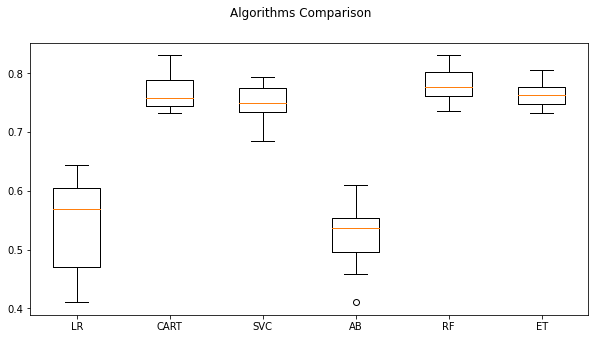

In [119]:
# Compare Algorithms
fig = plt.figure(figsize=(10,5))
fig.suptitle('Algorithms Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Valutazione dei migliori algoritmi (MLP, GB e RF) su test